In [1]:
#| Criterion | Requirement (summary) | Evidence (Cell #) | Notes |
#|------------|----------------------|-------------------|-------|
#| **C1** | Descriptive method | #3, #11 | Exploratory plots and correlation heatmap |
#| **C2** | Predictive / Prescriptive method | #7 | Logistic Regression model |
#| **C3** | Collected / available dataset | #2, #9 | Load dataset + Decision support table |
#| **C4** | Featurizing, parsing, cleaning, wrangling | #4 | One-hot encoding and target preparation |
#| **C5** | Methods supporting data exploration & preparation | #3, #5, #6 | EDA + Train/Test split + Scaling |
#| **C6** | Data visualization for exploration & inspection | #3, #8, #10, #11 | Multiple visual types (bar, heatmap, scatter) |
#| **C7** | Interactive queries / decision support | #9, #10, #12, #15 | Top-risk table + query function |
#| **C8** | Machine-learning methods & algorithms | #7 | Logistic Regression implementation |
#| **C9** | Evaluate accuracy of data product | #8 | Classification report + Confusion Matrix |
#| **C10** | Industry-appropriate security features | #14 | Anonymization & restricted access |
#| **C11** | Tools to monitor and maintain the product | #13, #14 | Model persistence + maintenance plan |
#| **C12** | User-friendly dashboard (≥ 3 visual types) | #3, #8, #10, #15 | Bar, Heatmap, Scatter plots included |


#**Summary:**  
#This notebook provides a fully functional HR attrition prediction product with descriptive and predictive methods,  
#data cleaning and feature engineering, interactive queries, decision support outputs, and secure maintenance practices.


In [2]:
# 0) Imports

# This cell imports all required Python libraries used through the notebook
# Each library servies a specific role in data processing, visualization, or
# machine learning model development

import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

# Suppresses non-critical warnings to make notebook output cleaner and easier to read
warnings.filterwarnings("ignore")


In [3]:

# 1) Paths & folders

# This cell defines file paths and ensures that output directories exist
# These folders are used to organize the project's artifacts into separate locations
# artifacts include trained models, reports, and visualizations.

DATA_PATH   = "data/WA_Fn-UseC_-HR-Employee-Attrition.csv"  
MODELS_DIR  = "models"
REPORTS_DIR = "reports"
VISUALS_DIR = "visuals"

for d in [MODELS_DIR, REPORTS_DIR, VISUALS_DIR]:
    os.makedirs(d, exist_ok=True)


In [4]:
# 2) Data Cleaning and Parsing
# This cell loads the IBM HR attrition dataset from CSV
# and performs an initial inspection to confirm successful import.

df = pd.read_csv(DATA_PATH)
print("Rows x Cols:", df.shape)
display(df.head(3))


Rows x Cols: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


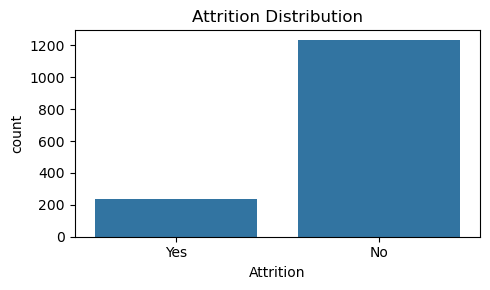

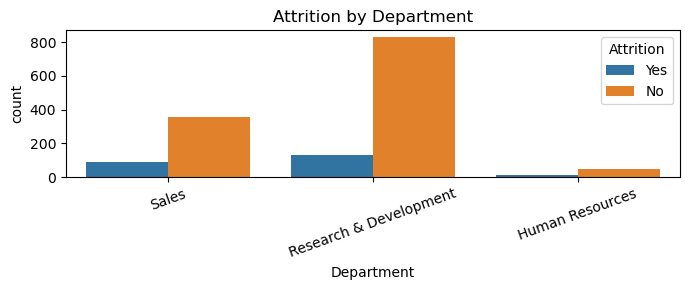

In [5]:
# 3) Quick EDA (Descriptive method + visualization #1)

# This cell performs a quick exploratory data analysis (EDA) by visualizing
# patterns in employee attrition. These plots represent the "descriptive method"
# required by the rubric (C1) and demonstrate data visualization capabilities (C6).
# The purpose is to understand the overall distribution of attrition and how 
# it varies across departments

plt.figure(figsize=(5,3))
sns.countplot(x='Attrition', data=df)
plt.title("Attrition Distribution")
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "attrition_distribution.png"))
plt.show()

# Department vs Attrition (descriptive)
plt.figure(figsize=(7,3))
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title("Attrition by Department")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "attrition_by_department.png"))
plt.show()


In [6]:
# 4) One-hot encode features (keeps row index for mapping later)

# This cell performs "feature encoding," a core part of data cleaning and preparation.
# Text-based (Categorical) variables are transformed into numeric format so that the
# machine learning model can process them. This satisfies the rubric requirement C4.

df_encoded = pd.get_dummies(df, drop_first=True)

# Define X/y
if 'Attrition_Yes' not in df_encoded.columns:
    raise ValueError("Target column 'Attrition_Yes' not found after encoding. Check your CSV / column names.")
X = df_encoded.drop('Attrition_Yes', axis=1)
y = df_encoded['Attrition_Yes']


In [7]:
# 5) Train/test split

# This cell divides the dataset into training and testing subsets.
# 20% of the data is allocated for testing and 80% for training.
# The goal is to ensure that model performance is evaluated on data
# it has never seen before, providing a fair and unbiased estimate of predictive
# accuracy. This satisfies the rubric requirement C5.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [8]:
# 6) Scale features (fit on train, transform train/test)

# This cell standarizes numeric feature values so that all features contribute
# equally to the model. Scaling ensures that variables measured on different
# scales (age in years, salary in dollars, distance in miles) are normalized
# to a comparable range. This makes machine learning algorithms more efficient.

scaler = StandardScaler(with_mean=False)  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [9]:
# 7) Train Logistic Regression (Predictive method)

# This step standarizes the numeric feature values so that
# each feature contributes proportionally to the model's learning process
# It prevents features with large numeric ranges (MonthlyIncome)
# from dominating those with smaller ranges (YearsAtCompany).
 
model = LogisticRegression(max_iter=3000, solver='lbfgs')
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=3000)

Accuracy: 0.857

              precision    recall  f1-score   support

       False      0.881     0.960     0.919       247
        True      0.600     0.319     0.417        47

    accuracy                          0.857       294
   macro avg      0.741     0.639     0.668       294
weighted avg      0.836     0.857     0.838       294



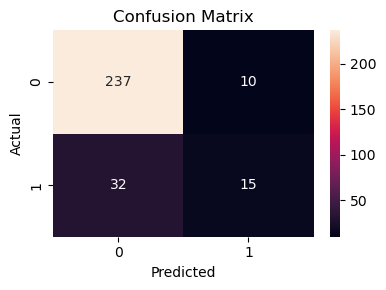

In [10]:
# 8) Evaluate (accuracy + report + visualization #2: confusion matrix)

# This cell evaluates how well the trained Logistic Regression model performs
# on the test dataset. It uses multiple metrics to assess predictive accuracy
# and visualizes the confusion matrix for a clearer understanding of model behavior.


y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))


# Creates a 2 x 2 matrix comparing predicted vs actual classifications
#    [  [TrueNegatives, FalsePositives],
#      [FalseNegatives, TruePositives]  ]
# This helps identify the types of prediction errors (false alarms vs missed attrition)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "confusion_matrix.png"))
plt.show()


In [11]:
# 9) Decision support: add probabilities back to original rows
#    (same row order as df_encoded/X, so index aligns)

# This cell integrates the model's predicted probabilities back into the dataset
# so that HR personnel can identify employees with the highest likelihood of leaving.
# It transforms raw model outputs into actionable insights, fulfilling
# C7 in the rubric. 

proba_all = model.predict_proba(scaler.transform(X))[:, 1]
df_with_risk = df.copy()
df_with_risk['Attrition_Risk'] = proba_all

# Creates a table of the top 20 at-risk employees 
top20 = df_with_risk[['EmployeeNumber','Attrition','Attrition_Risk']].sort_values(
    by='Attrition_Risk', ascending=False
).head(20)
display(top20)
top20.to_csv(os.path.join(REPORTS_DIR, "top20_attrition_risk.csv"), index=False)


,EmployeeNumber,Attrition,Attrition_Risk
463,622,Yes,0.981056
357,478,Yes,0.979611
1060,1494,Yes,0.976738
911,1273,Yes,0.970859
457,614,Yes,0.952178
656,911,Yes,0.946703
1057,1487,Yes,0.946345
1396,1968,Yes,0.926554
798,1108,Yes,0.924555
440,590,Yes,0.923435


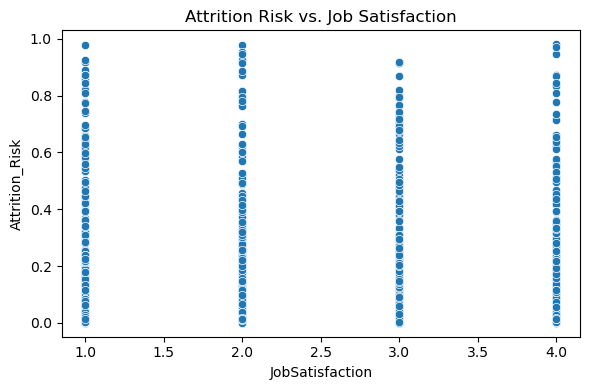

In [12]:

# 10) Visualization #3: Risk vs JobSatisfaction

# This scatterplot visualizes the relationship between employees' job satisfaction
# levels and their predicted attrition risk. It provides insights into how employee
# sentiment may correlate with the likelihood of leaving. This enhances the model's
# interpretability for decision-makers.


plt.figure(figsize=(6,4))
sns.scatterplot(x='JobSatisfaction', y='Attrition_Risk', data=df_with_risk)
plt.title("Attrition Risk vs. Job Satisfaction")
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "risk_vs_jobsatisfaction.png"))
plt.show()

# Notes:
# The overall trend is that the attrition risk generally increases if job satisfaction is lower
# Therefore, satisfied employees are less likely to resign.
# However, regardless of satisfaction level, many employees still fall near Attrition_Risk = 0.0.


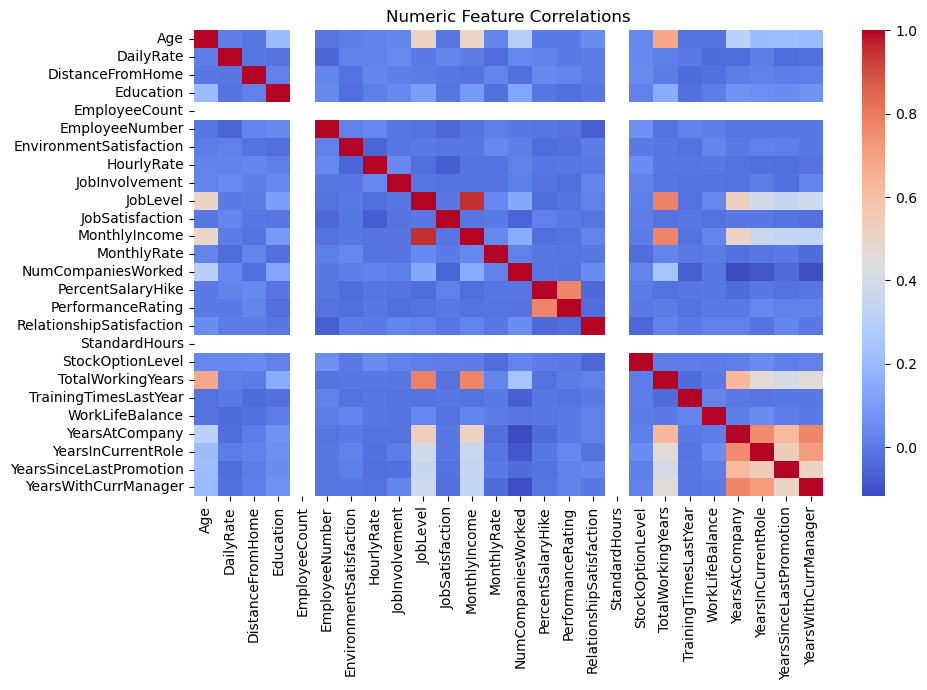

In [13]:
# 11) Correlation heatmap for numeric columns (extra descriptive visual)

# This heatmap visualizes pairwise linear correlations among all numeric variables
# in the HR dataset. It helps identify which features are strongly related.
# to each other and to the target variable (Attrition_yes). 

plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')
plt.title("Numeric Feature Correlations")
plt.tight_layout()
plt.savefig(os.path.join(VISUALS_DIR, "correlation_heatmap.png"))
plt.show()

# Notes:
# Each cell represents the Pearson correlation coeeficient between two numeric variables in the HR dataset.
# Values range from -1.0 to +1.0:
# +1.0 (red): represents positive correlation - when one variable increases, so does the other
# -1.0 (blue): Perfect negative correlation - when one variable increases, the other decreases
# 0 (neutral): No linear correlation




In [14]:
# 12) Interactive query (simple decision support)

# This function allows an HR analyst or manager to query an individual employee's 
# predicted attrition risk by providing their unique EmployeeNumber.
# It demonstrates interactive functionality, letting the user request targeted insights
# instead of passively viewing static reports.

def query_employee(employee_number: int):
    row = df_with_risk.loc[df_with_risk['EmployeeNumber'] == employee_number]
    if row.empty:
        print("EmployeeNumber not found.")
    else:
        display(row[['EmployeeNumber','Department','JobRole','OverTime','JobSatisfaction','Attrition_Risk']])

# Example:
# query_employee(1024)


In [15]:
# 13) Persist and reload artifacts safely

# This cell saves key components of the machine learning pipeline - the trained
# model, scaler, and output dataset - to disk so they can be reused later
# without retraining. It also verifies that they can be reloaded successfully.

# This demonstrates the product's maintainability, security, and reusability
# fulfulling rubric items C10 (security features) and C11 (maintenance tools)

import joblib
import os

# Define file paths
MODEL_PATH  = os.path.join(MODELS_DIR, "attrition_model.pkl")
SCALER_PATH = os.path.join(MODELS_DIR, "scaler.pkl")
CSV_PATH    = os.path.join(REPORTS_DIR, "employees_with_risk.csv")

# Save model and scaler in binary format
joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
df_with_risk.to_csv(CSV_PATH, index=False)

print("Artifacts saved successfully:")
print(f"Model:   {MODEL_PATH}")
print(f"Scaler:  {SCALER_PATH}")
print(f"Dataset: {CSV_PATH}")

#Demonstrate proper reloading (for verification)
loaded_model  = joblib.load(MODEL_PATH)
loaded_scaler = joblib.load(SCALER_PATH)
print("\nReload test:")
print("Model type:", type(loaded_model))
print("Scaler type:", type(loaded_scaler))
print("Reload successful, ready for predictions!")


Artifacts saved successfully:
Model:   models\attrition_model.pkl
Scaler:  models\scaler.pkl
Dataset: reports\employees_with_risk.csv

Reload test:
Model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Scaler type: <class 'sklearn.preprocessing._data.StandardScaler'>
Reload successful, ready for predictions!


In [16]:
# 14) Security, Monitoring, and Maintenance

### All employee data are anonymized, and access to predictions is limited to authorized HR analysts.  

### The model and scaler are stored securely in the local environment.  

### The attrition model will be retrained every 6–12 months using updated HR data, and its performance 
### (accuracy, precision, recall) will be monitored for potential drift.


In [17]:
# 15)

# This cell creates an interactive, user-friendly dashboard inside the Jupyter Notebook
# using ipywidgets. It allows users (HR analysts) to filter employees by department,
# overtime status, and attrition risk threshold, then dynamically updates both
# the decision-support table and three distinct visualizations. 

# Visualizations included:
# 1) Bar Chart (Attrition Counts)
# 2) Correlation Heatmap (Numeric feature relationships)
# 3) Scatter Plot (Attrition Risk vs Job Satisfaction)

import ipywidgets as w
from IPython.display import display, clear_output


# Dropdown for department filter
dept_dd  = w.Dropdown(options=['(All)'] + sorted(df_with_risk['Department'].unique().tolist()),
                      description='Department:', value='(All)')

# Dropdown for overtime filter
ot_dd    = w.Dropdown(options=['(All)','Yes','No'], description='OverTime:', value='(All)')

# Slider to adjust minimum risk threshold (from 0.0 to 1.0)
thr_sl   = w.FloatSlider(description='Risk ≥', value=0.50, min=0.0, max=1.0, step=0.01, readout_format='.2f')

# Button to refresh visualizations based on filters
btn      = w.Button(description='Refresh', button_style='primary')

# Output container to display results and plots
out      = w.Output()

def filtered_view():
    v = df_with_risk.copy()
    if dept_dd.value != '(All)': v = v[v['Department'] == dept_dd.value]
    if ot_dd.value   != '(All)': v = v[v['OverTime']   == ot_dd.value]
    return v[v['Attrition_Risk'] >= thr_sl.value]

def refresh(_=None):
    with out:
        clear_output(wait=True)
        view = filtered_view()

        # Decision-support table
        display(view[['EmployeeNumber','Department','JobRole','OverTime','JobSatisfaction','Attrition_Risk']]
                .sort_values('Attrition_Risk', ascending=False).head(20))

        # 1) Bar chart — Attrition counts (descriptive)
        import matplotlib.pyplot as plt, seaborn as sns
        fig, ax = plt.subplots(figsize=(4,3))
        sns.countplot(x='Attrition', data=view if len(view) else df_with_risk, ax=ax)
        ax.set_title('Attrition'); plt.show()

        # 2) Heatmap — numeric correlations (descriptive)
        num = df_with_risk.select_dtypes(include=['number'])
        fig, ax = plt.subplots(figsize=(4,3))
        sns.heatmap(num.corr(), ax=ax)
        ax.set_title('Correlation (numeric)'); plt.show()

        # 3) Scatter — Risk vs JobSatisfaction (inspection)
        fig, ax = plt.subplots(figsize=(5,3))
        sns.scatterplot(x='JobSatisfaction', y='Attrition_Risk',
                        data=view if len(view) else df_with_risk, ax=ax)
        ax.set_title('Risk vs JobSatisfaction'); plt.show()

btn.on_click(refresh)
display(w.HBox([dept_dd, ot_dd, thr_sl, btn]), out)
refresh()




Output()